Necessary import statements

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

Loading the HTRU dataset and displaying the first few rows

There are 8 feature variables and a class variable, which is either 0 or 1

The feature variables are described by the dataset owner as follows:


>Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency. The remaining four variables are similarly obtained from the DM-SNR curve. These are summarised below:
>
>1. Mean of the integrated profile.
>2. Standard deviation of the integrated profile.
>3. Excess kurtosis of the integrated profile.
>4. Skewness of the integrated profile.
>5. Mean of the DM-SNR curve.
>6. Standard deviation of the DM-SNR curve.
>7. Excess kurtosis of the DM-SNR curve.
>8. Skewness of the DM-SNR curve.
>9. Class

In [ ]:
# given by the dataset
column_names = [
    "Mean_Integrated_Profile", "Std_Integrated_Profile", "Kurtosis_Integrated_Profile", "Skewness_Integrated_Profile",
    "Mean_DM_SNR", "Std_DM_SNR", "Kurtosis_DM_SNR", "Skewness_DM_SNR", "Class"
]

df = pd.read_csv("/content/HTRU_2.csv", names=column_names)
df.head()

,Mean_Integrated_Profile,Std_Integrated_Profile,Kurtosis_Integrated_Profile,Skewness_Integrated_Profile,Mean_DM_SNR,Std_DM_SNR,Kurtosis_DM_SNR,Skewness_DM_SNR,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


Using t-SNE algorithm to visualize data

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

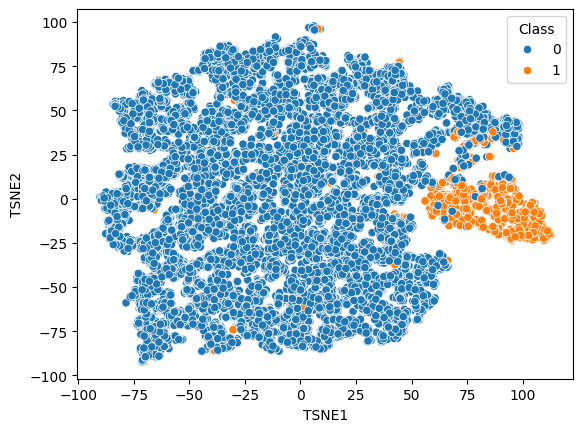

In [ ]:
# standardize the data before t-SNE
features = df.iloc[:, :-1]
labels = df['Class']

scaled_features = StandardScaler().fit_transform(features)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Class'] = labels

tsne_df['TSNE1'] = tsne_results[:,0]
tsne_df['TSNE2'] = tsne_results[:,1]

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Class', data=tsne_df)

Creating a seaborn pairplot to show feature correlation

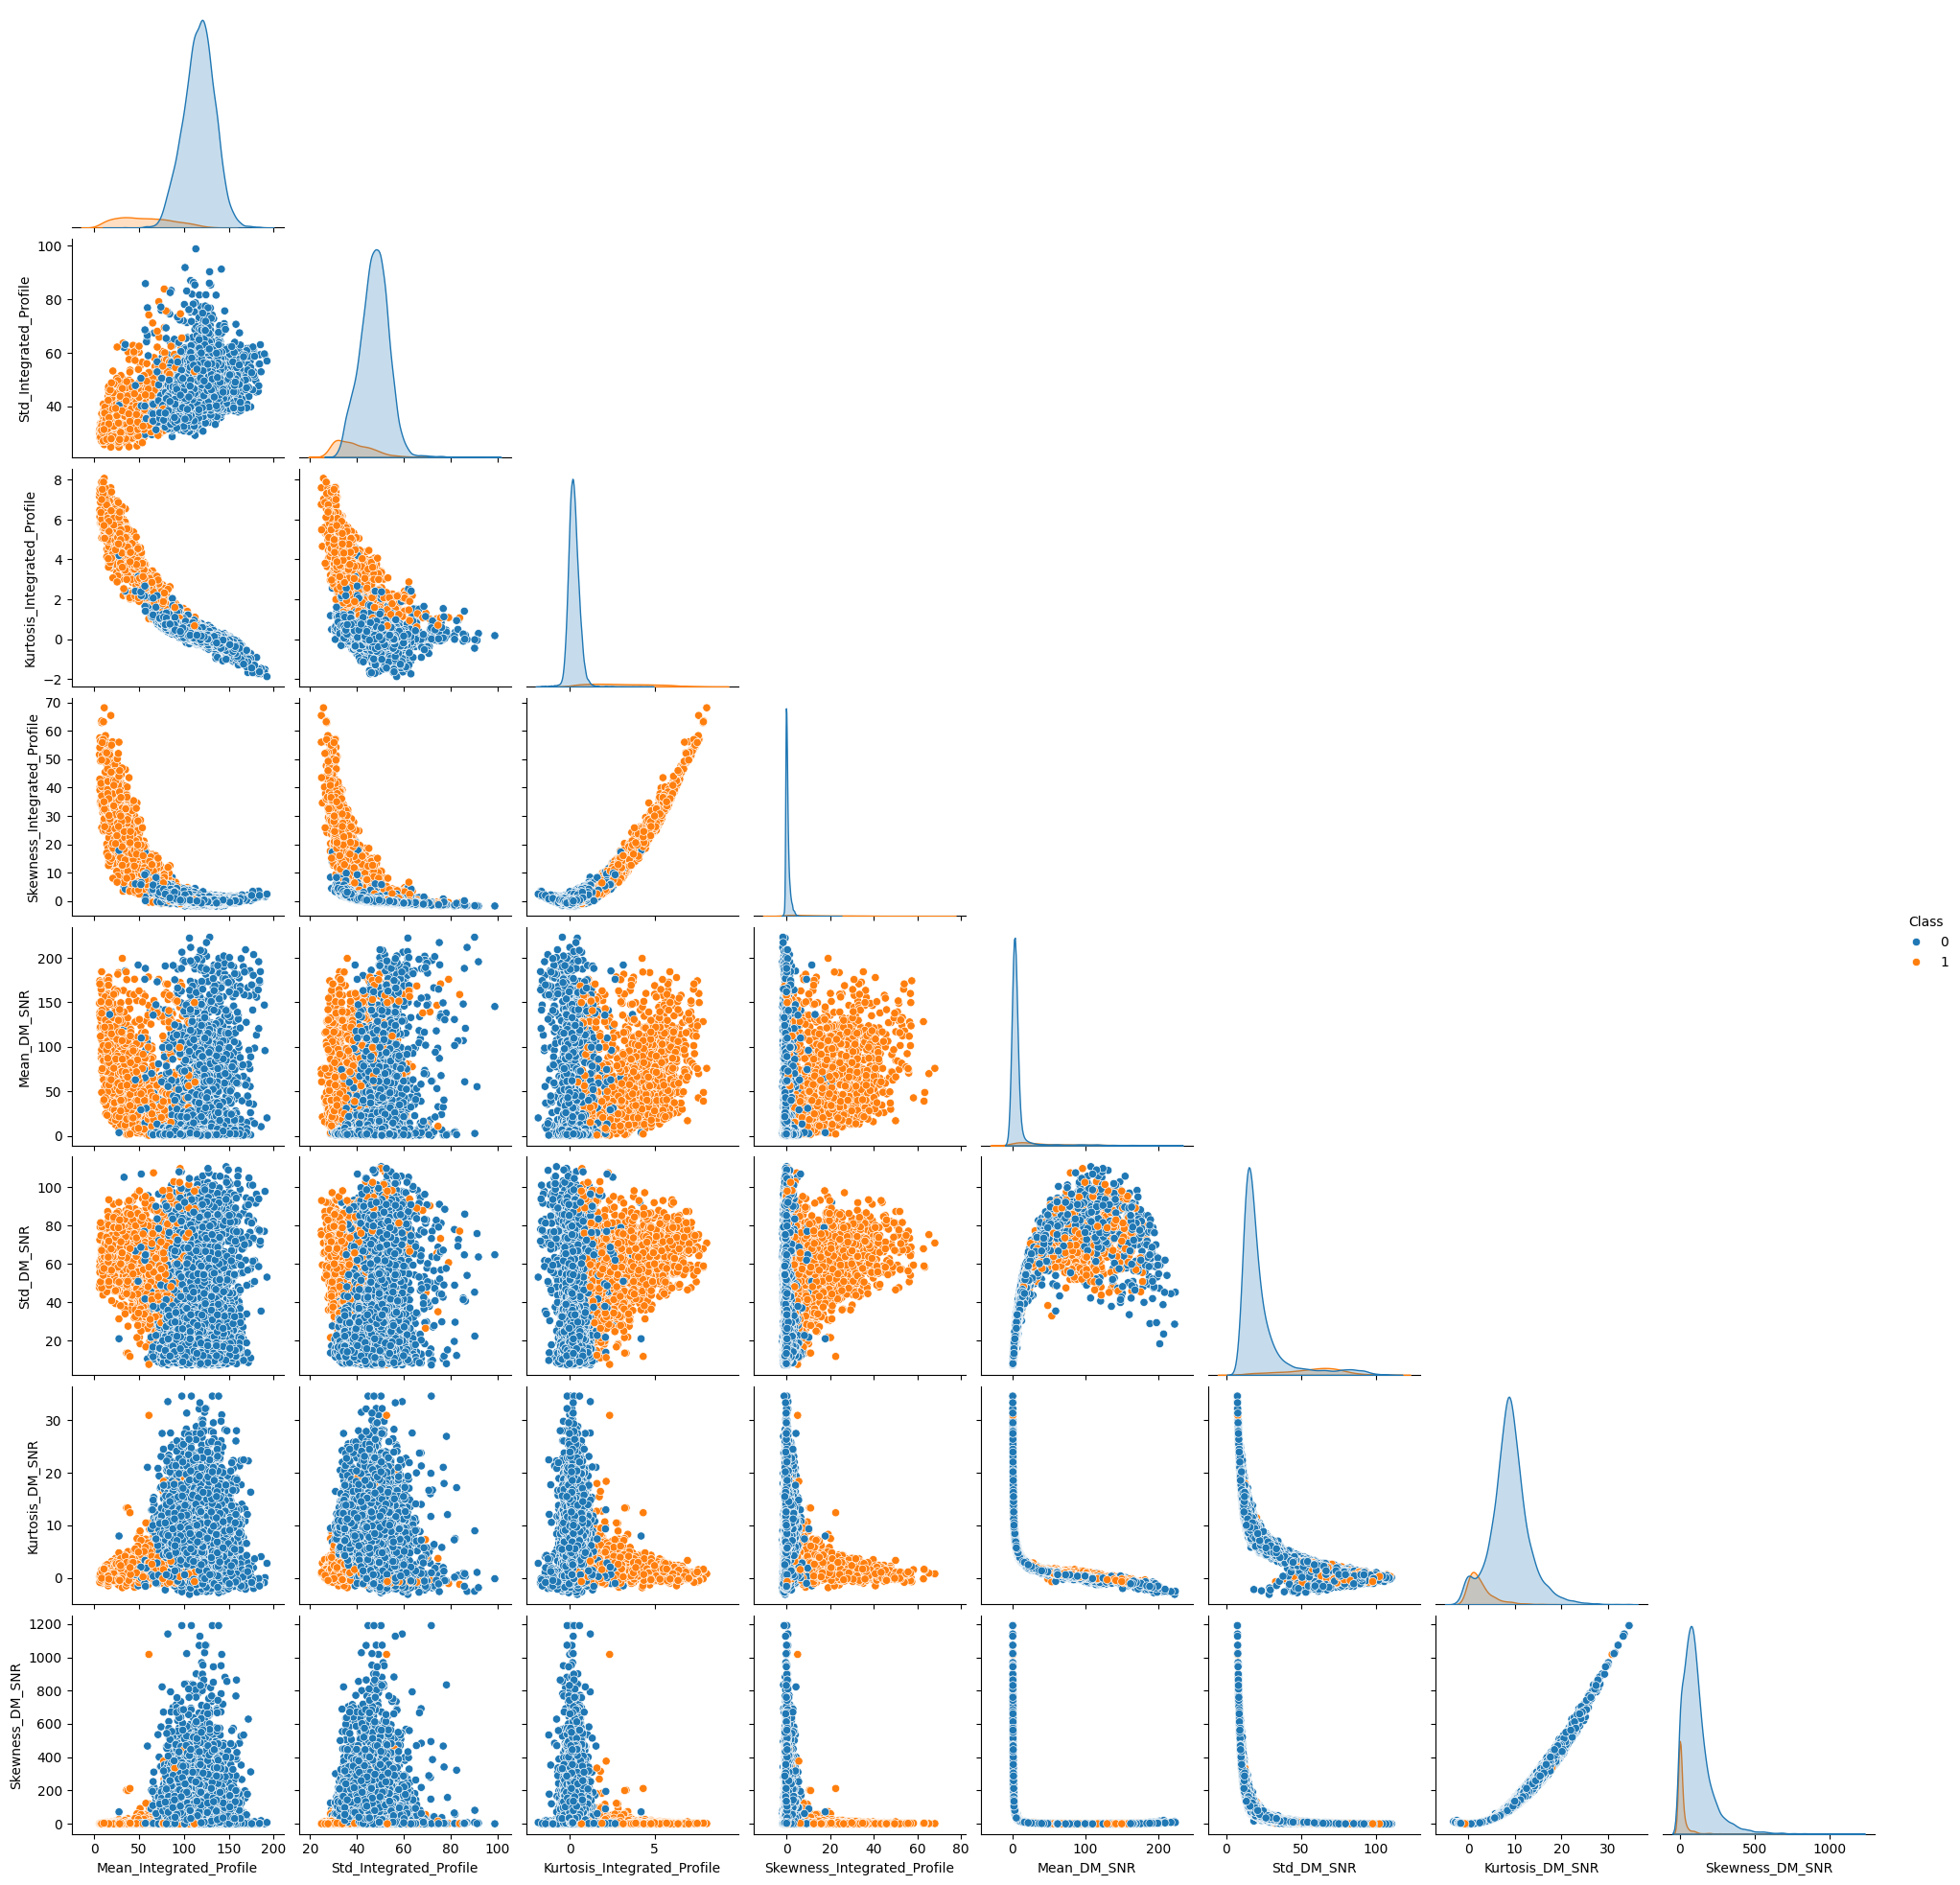

In [ ]:
import seaborn as sns

# create pairplot
sns.pairplot(df, hue='Class', diag_kind='kde', corner=True)

Previous pairplot ended up not being that useful, so made feature correlation heatmap

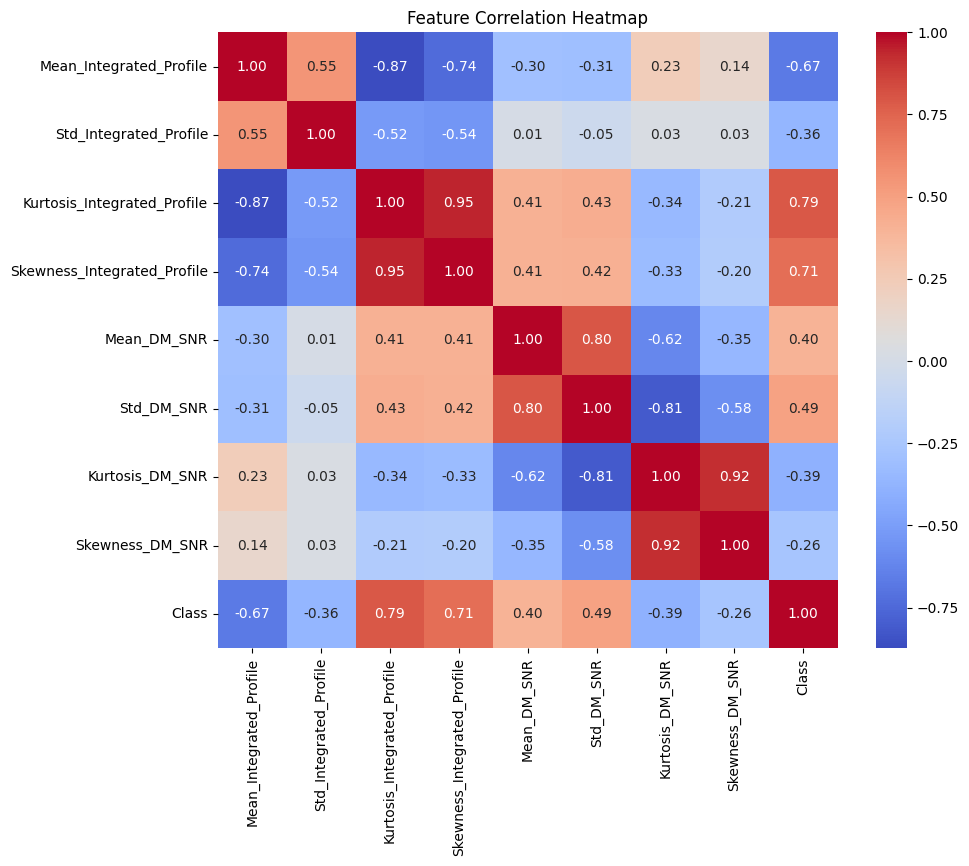

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

Implementation of a binary perceptron model

Adapted from work done in CPSC 381 under Professor Alex Wong

In [ ]:
class BinaryPerceptron:
    '''
    Implementation of Binary Perceptron
    '''

    def __init__(self):
        self.__weights = None

    def __update(self, x, y):
        '''
        Update weights for misclassified examples

        Arg(s):
            x : numpy.ndarray
                Feature vector of shape d x 1
            y : int
                Label/target (-1 or 1)
        '''

        # TODO: Implement weight update rule for binary perceptron
        self.__weights += y * x


    def fit(self, x, y, max_iter=100):
        '''
        Fit the binary perceptron to training data

        Arg(s):
            x : numpy.ndarray
                Features of shape d x N
            y : numpy.ndarray
                Labels/targets of shape 1 x N
            max_iter : int
                Maximum number of iterations
        '''

        n_features, n_samples = x.shape

        # Initialize weights (including a bias term, w0) as zeros vector with shape d+1 x 1
        self.__weights = np.zeros((n_features + 1, 1))

        # Append artificial coordinate (x0) to the data
        x = np.vstack((np.ones((1, n_samples)), x))

        # Implement training loop
        for _ in range(max_iter):
            n_updates = 0

            # Process each sample
            for n in range(n_samples):
                # TODO: Calculate prediction
                x_n = x[:, n].reshape(-1, 1)
                y_hat = np.sign(np.matmul(self.__weights.T, x_n))

                # TODO: Update weights if misclassified
                if y_hat != y[0, n]:
                  self.__update(x_n, y[0, n])
                  n_updates +=1

            # Break if no updates were made, e.g., check for convergence
            if n_updates == 0:
              break


    def predict(self, x):
        '''
        Make predictions

        Arg(s):
            x : numpy.ndarray
                Features of shape d x N

        Returns:
            numpy.ndarray : Predicted labels (-1 or 1) of 1 x N
        '''

        n_features, n_samples = x.shape

        # Append artificial coordinate (x0) to the data
        x = np.vstack((np.ones((1, n_samples)), x))

        # Implement prediction logic
        return np.sign(np.matmul(self.__weights.T, x))

    def score(self, x, y):
        '''
        Calculate prediction accuracy

        Arg(s):
            x : numpy.ndarray
                Features of shaped d x N
            y : numpy.ndarray
                Labels/targets of shape 1 x N

        Returns:
            float: Accuracy score
        '''

        # Implement accuracy calculation
        y_hat = self.predict(x)
        return np.mean(y_hat == y)

Preparing the dataset for training for the perceptron

In [ ]:
def prepare_data_for_binary_perceptron(df):
  '''
  Prepare binary classification dataset from digits

  Args:
      df: the HTRU dataset as a dataframe

  Returns:
      tuple: (X_train, y_train, X_val, y_val, X_test, y_test)
          X_train : d x N
          y_train : 1 x N
          X_val : d x M
          y_val : 1 x M
          X_test : d x P
          y_test : 1 x P
  '''

  # extract data from dataframe
  X = df.iloc[:, :-1].values
  y = df.iloc[:, -1].values

  # convert labels to -1/1
  y = np.where(y == 0, -1, 1)
  y = np.expand_dims(y, axis=-1)

  # use scikit test_train_split to create training, validation, and testing splits
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

  # transpose resulting matrices into expected d x N
  X_train, X_val, X_test = X_train.T, X_val.T, X_test.T
  y_train, y_val, y_test = y_train.T, y_val.T, y_test.T

  return X_train, y_train, X_val, y_val, X_test, y_test

Training the perceptron on the dataset

Max iterations: 10, Validation accuracy: 0.9773
Model test accuracy: 0.9799


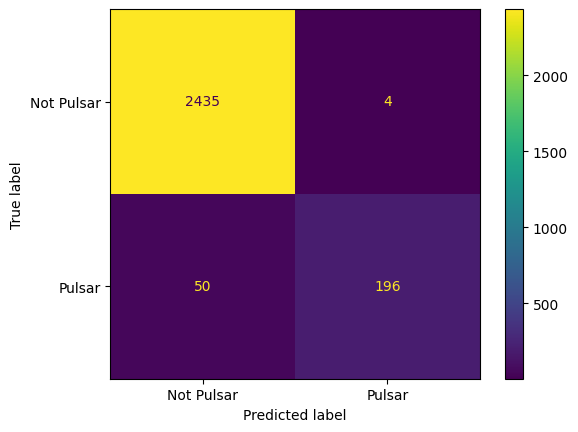

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_for_binary_perceptron(df)

# train model on training set
model = BinaryPerceptron()
model.fit(x=X_train, y=y_train, max_iter=10)

# calculate validation score
val_score = model.score(X_val, y_val)
print("Max iterations: {}, Validation accuracy: {:.4f}".format(10, val_score))

# test model
test_score = model.score(X_test, y_test)
print("Model test accuracy: {:.4f}".format(test_score))

# create a confusion matrix using skmetrics.confusion_matrix for your model on the test set
predictions_test = model.predict(X_test)
confusion_matrix = skmetrics.confusion_matrix(y_test.T, predictions_test.T)
confusion_matrix_plot = skmetrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=["Not Pulsar", "Pulsar"]).plot()

# Show confusion matrix
plt.show()

An attempt to train the perceptron on "cleaner" data, as indicated by the heatmap

In [ ]:
def prepare_data_for_binary_perceptron_clean(df):
  '''
  Prepare binary classification dataset from digits

  Args:
      df: the HTRU dataset as a dataframe

  Returns:
      tuple: (X_train, y_train, X_val, y_val, X_test, y_test)
          X_train : d x N
          y_train : 1 x N
          X_val : d x M
          y_val : 1 x M
          X_test : d x P
          y_test : 1 x P
  '''

  filtered_df = df[["Kurtosis_Integrated_Profile", "Skewness_Integrated_Profile", "Class"]]

  # extract data from dataframe
  X = filtered_df.iloc[:, :-1].values
  y = filtered_df.iloc[:, -1].values

  # convert labels to -1/1
  y = np.where(y == 0, -1, 1)
  y = np.expand_dims(y, axis=-1)

  # use scikit test_train_split to create training, validation, and testing splits
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

  # transpose resulting matrices into expected d x N
  X_train, X_val, X_test = X_train.T, X_val.T, X_test.T
  y_train, y_val, y_test = y_train.T, y_val.T, y_test.T

  return X_train, y_train, X_val, y_val, X_test, y_test

Max iterations: 10, Validation accuracy: 0.9780
Model test accuracy: 0.9791


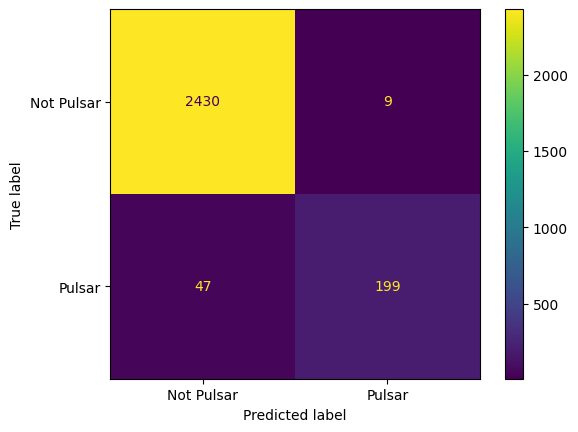

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data_for_binary_perceptron_clean(df)

# train model on training set
model = BinaryPerceptron()
model.fit(x=X_train, y=y_train, max_iter=10)

# calculate validation score
val_score = model.score(X_val, y_val)
print("Max iterations: {}, Validation accuracy: {:.4f}".format(10, val_score))

# test model
test_score = model.score(X_test, y_test)
print("Model test accuracy: {:.4f}".format(test_score))

# create a confusion matrix using skmetrics.confusion_matrix for your model on the test set
predictions_test = model.predict(X_test)
confusion_matrix = skmetrics.confusion_matrix(y_test.T, predictions_test.T)
confusion_matrix_plot = skmetrics.ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix,
        display_labels=["Not Pulsar", "Pulsar"]).plot()

# Show confusion matrix
plt.show()

Implementation of the SVM with RBF kernel

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Split the dataset
X = df.drop(columns=['Class']).values
y = df['Class'].values

# Train/validation/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', gamma=0.1, C=1.0)
svm_rbf.fit(X_train, y_train)

# Predict the labels of the testing data
y_pred = svm_rbf.predict(X_test)

# Calculate the accuracy of the classifier
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

Accuracy: 0.9824953445065177


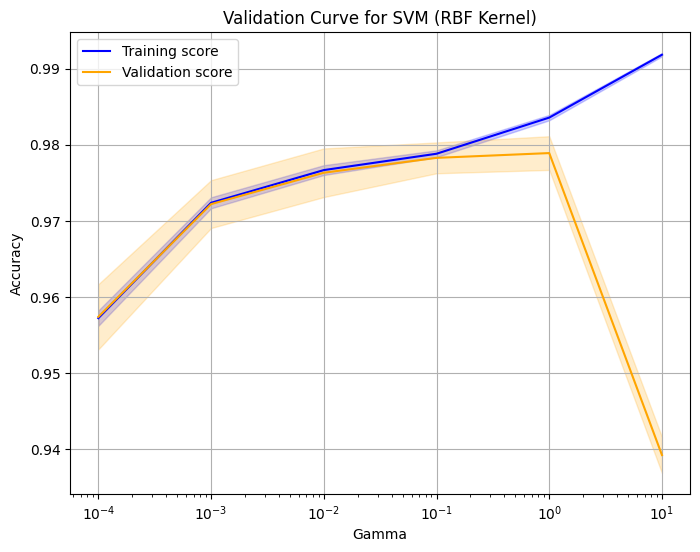

In [ ]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Try different values of gamma
param_range = np.logspace(-4, 1, 6)
train_scores, valid_scores = validation_curve(
    SVC(kernel='rbf'),
    X_train, y_train,
    param_name='gamma',
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)

# Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(param_range, train_mean, label='Training score', color='blue')
plt.plot(param_range, valid_mean, label='Validation score', color='orange')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='orange')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title('Validation Curve for SVM (RBF Kernel)')
plt.legend()
plt.grid(True)
plt.show()


Making the "dummy" datasets to test sk implementations of ML models

[]

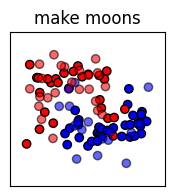

In [ ]:
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Classifiers:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

ds = make_moons(noise=0.3, random_state=12)

figure = plt.figure(figsize=(2,2))
X, y = ds
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot()
ax.set_title("make moons")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

Testing the scikit implementations of alternative models

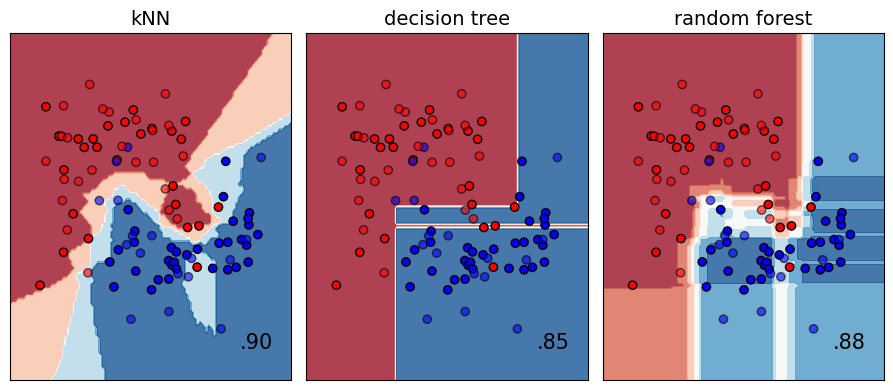

In [ ]:
# defining the classifiers we will be using

# kNN
knn = KNeighborsClassifier(3)

# decision tree
decision_tree = DecisionTreeClassifier(max_depth=5, random_state=12)

# random forest
random_forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=12)

names = ["kNN", "decision tree", "random forest"]
classifiers = [knn, decision_tree, random_forest]

# display all the classifiers
figure = plt.figure(figsize=(12,4))

# iterate over classifiers
i = 1
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    ax.set_title(name, fontsize=14)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )

    i += 1

plt.tight_layout()
plt.show()